## Backup: Plot seismicity data

In [11]:
%matplotlib inline

import os
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from mintpy.defaults.plot import *
from mintpy.utils import ptime, readfile, utils as ut, plot as pp

work_dir = os.path.expanduser('~/data/Kirishima/Seismic')
os.chdir(work_dir)
print('Go to directory', work_dir)

SNWE = (31.85, 32.0, 130.75, 130.93)
max_depth = 15

Go to directory /Users/yunjunz/insarlab/Kirishima/Seismic


In [3]:

def read_oikawa(fname, SNWE=None, max_depth=None):
    #fname = os.path.expanduser('~/insarlab/Kirishima/Seismic/aizawa.txt')
    fc = np.loadtxt(fname, dtype=bytes).astype(str)
    lats   = np.array([float(i.split('N')[0]) for i in fc[:,3].tolist()])
    lons   = np.array([float(i.split('E')[0]) for i in fc[:,4].tolist()])
    depths = np.array([float(i.split('km')[0]) for i in fc[:,5].tolist()]) * -1000
    mags   = np.array([float(i.split('M')[1]) for i in fc[:,6].tolist()])
    dates = []
    for i in range(len(depths)):
        dti_str = fc[i,1]
        dti = datetime.datetime(*time.strptime(dti_str, "%y/%m/%d")[0:5])
        dates.append(dti)
    dates = np.array(dates)

    mask = np.ones(depths.shape, dtype=np.bool_)
    if max_depth is not None:
        mask = depths > max_depth
    if SNWE is not None:
        mask *= lats >= SNWE[0]
        mask *= lats <= SNWE[1]
        mask *= lons >= SNWE[2]
        mask *= lons <= SNWE[3]
    print('number of EQs: {}'.format(np.sum(mask)))
    dates = dates[mask]
    lats = lats[mask]
    lons = lons[mask]
    depths = depths[mask]
    mags = mags[mask]
    return dates, lats, lons, depths, mags


def read_jma(fname, SNWE):
    """JMA catalog
    Link: http://www.data.jma.go.jp/svd/eqev/data/bulletin/data/format/hypfmt_e.html
    """
    #fname = os.path.expanduser('~/insarlab/Kirishima/Seismic/h2008')
    with open(fname, 'r') as f:
        lines = f.readlines()
    num_line = len(lines)

    prog_bar = ptime.progressBar(maxValue=num_line)
    dates = []
    lats = []
    lons = []
    depths = []
    for i in range(num_line):
        prog_bar.update(i+1, every=1000, suffix='line {} / {}'.format(i+1, num_line))
        l = lines[i].strip()
        if l[0] in ['J','I']:
            dt_str = '{}{}{}'.format(l[1:5], l[5:7], l[7:9])
            dti = datetime.datetime(*time.strptime(dt_str, "%Y%m")[0:5])
            lat = float(l[21:24]) + float('{}.{}'.format(l[24:26],l[26:28]))/60.
            lon = float(l[32:36]) + float('{}.{}'.format(l[36:38],l[38:40]))/60.
            depth = float('{}.{}'.format(l[44:47], l[47:49]))

            # update list
            if SNWE[0] <= lat <= SNWE[1] and SNWE[2] <= lon <= SNWE[3]:
                dates.append(dti)
                lats.append(lat)
                lons.append(lon)
                depths.append(depth)
    prog_bar.close()
    lats = np.array(lats)
    lons = np.array(lons)
    depths = np.array(depths)
    print('number of events: {}'.format(len(lats)))
    return dates, lats, lons, depths


def read_jma_yosuke(fname, SNWE, max_depth=None):
    """JMA catalog prepared by Yosuke"""
    #fname = os.path.expanduser('~/insarlab/Kirishima/Seismic/Kirishima_seis_2008_2018.txt')
    fc = np.loadtxt(fname, dtype=bytes).astype(str)
    num_row = fc.shape[0]
    
    year = fc[:,0]
    month = fc[:,1]
    day = fc[:,2]
    dates = []
    for i in range(num_row):
        dti_str = year[i]+month[i]+day[i]
        dti = datetime.datetime(*time.strptime(dti_str, "%Y%m%d")[0:5])
        dates.append(dti)
    dates = np.array(dates)

    lons = fc[:,6].astype(np.float32)
    lats = fc[:,7].astype(np.float32)
    depths = fc[:,8].astype(np.float32)
    mags = fc[:,9].astype(np.float32)

    mask = np.ones(depths.shape, dtype=np.bool_)
    if max_depth is not None:
        mask = depths > max_depth
    if SNWE is not None:
        mask *= lats >= SNWE[0]
        mask *= lats <= SNWE[1]
        mask *= lons >= SNWE[2]
        mask *= lons <= SNWE[3]
    print('number of EQs: {}'.format(np.sum(mask)))
    dates = dates[mask]
    lats = lats[mask]
    lons = lons[mask]
    depths = depths[mask]
    mags = mags[mask]
    return dates, lats, lons, depths, mags


def get_monthly_num(dates):
    # get all months in range
    from dateutil.relativedelta import relativedelta
    months = []
    date1 = datetime.datetime(dates[-1].year, dates[-1].month, 1, 0, 0)
    datei = datetime.datetime(dates[0].year, dates[0].month, 1, 0, 0)
    while datei <= date1:
        months.append(datei)
        datei += relativedelta(months=1)
    months = np.array(months)

    # count the number
    nums = np.zeros(months.shape, dtype=np.int16)
    for datei in dates:
        idx = np.where(months <= datei)[0][-1]
        nums[idx] += 1
    return months, nums


def plot_data(lats, lons, depths, mags):
    # histogram
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 3], sharey=True)
    axs[0].hist(depths, bins=50)
    axs[1].hist(mags, bins=50)
    axs[0].set_xlabel('depth')
    axs[1].set_xlabel('depth')
    axs[0].set_ylabel('number of EQ')
    
    # transection
    plt.figure()
    plt.plot(lons, depths, '.', ms=1, color='r')
    plt.show()

#outfile = os.path.expanduser('~/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/aizawa.xyz')
#np.savetxt(outfile, np.hstack((lons.reshape(-1,1),
#                               lats.reshape(-1,1),
#                               depths.reshape(-1,1))), fmt='%8.4f', delimiter='\t')

number of events: 2826
save figure to file /Users/yunjunz/insarlab/Kirishima/Seismic/seis_depth15.png


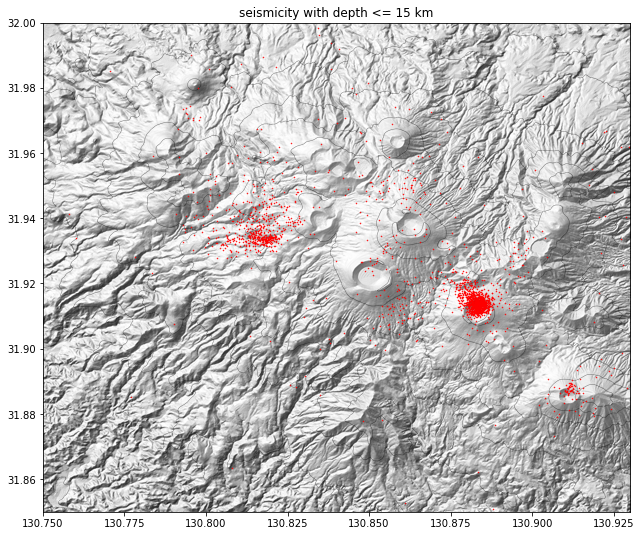

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[12, 9])
m = pp.BasemapExt(llcrnrlon=SNWE[2], llcrnrlat=SNWE[0],
                  urcrnrlon=SNWE[3], urcrnrlat=SNWE[1],
                  projection='cyl', resolution='h',
                  suppress_ticks=False, ax=ax)

# read DEM
dem_file = os.path.join(work_dir, '../DEM/Kirishima.dem.wgs84')
geo_box = (SNWE[2], SNWE[1], SNWE[3], SNWE[0])
pix_box = ut.coordinate(readfile.read_attribute(dem_file)).bbox_geo2radar(geo_box)
dem = readfile.read(dem_file, box=pix_box)[0]
# plot DEM
m = pp.plot_dem_background(ax=m, geo_box=geo_box, dem=dem, print_msg=False)

idx = depths <= max_depth
ax.set_title('seismicity with depth <= {} km'.format(max_depth))
ax.plot(lons[idx], lats[idx], '.', ms=1, color='r')
print('number of events: {}'.format(len(lats)))

# output
out_file = os.path.join(work_dir, 'seis_depth{}.png'.format(int(max_depth)))
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=150)
print('save figure to file', out_file)
plt.show()

In [14]:
#SNWE = (31.88, 31.92, 130.85, 130.92)
#dates, lats, lons, depths, mags = read_jma_yosuke(os.path.join(work_dir, 'Kirishima_seis_2008_2018.txt'), SNWE=SNWE)
dates, lats, lons, depths, mags = read_oikawa(os.path.join(work_dir, 'aizawa.txt'), SNWE=SNWE)

number of EQs: 2826


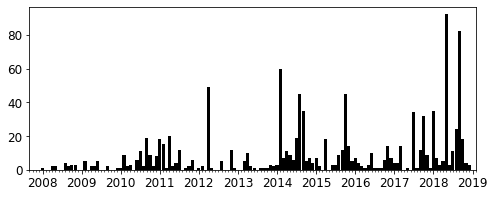

In [13]:
months, nums = get_monthly_num(dates)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8,3])
ax.bar(months, nums, width=datetime.timedelta(30), color='k')
pp.auto_adjust_xaxis_date(ax, months)
plt.show()

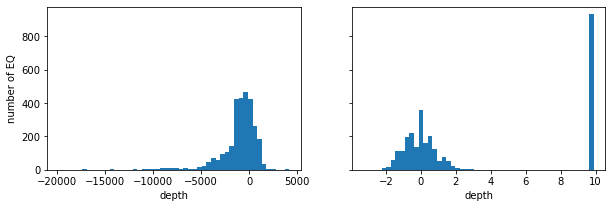

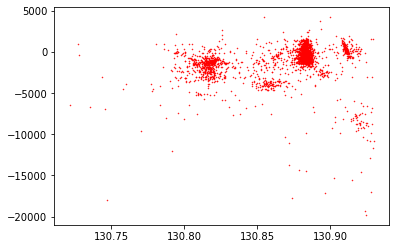

In [20]:
plot_data(lats, lons, depths, mags)